In [1]:
import gdown
!rm -r /content/sample_data # i hate a lot this folder
path = 'https://drive.google.com/file/d/159TvOcNq6C2KMHA5Mt3V0z3GTNzzj9Hh/view?usp=share_link'
link = path.split('/')
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={link[-2]}",
    'heartdatatrain.zip'
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=159TvOcNq6C2KMHA5Mt3V0z3GTNzzj9Hh
To: /content/heartdatatrain.zip
100%|██████████| 128M/128M [00:05<00:00, 23.0MB/s]


'heartdatatrain.zip'

In [2]:
%%capture
!unzip heartdatatrain.zip

In [3]:
%%capture
!pip install --upgrade transformers
!pip install pytorch-lightning
!pip install wandb

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.metrics import accuracy_score
import os
import cv2
import numpy as np
from numpy import load
import albumentations as A
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from fastprogress import master_bar, progress_bar
from transformers import SegformerForSemanticSegmentation # , SegformerFeatureExtractor
import wandb

print('albumentations :', A.__version__)
print('pytorch_lightning :', pl.__version__)
print("torch :", torch.__version__)

albumentations : 1.2.1
pytorch_lightning : 1.8.6
torch : 1.13.1+cu116


In [5]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        #self.train = train
        self.transforms = transforms
        #self.num_classes = 4

        #sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, "images")
        self.ann_dir = os.path.join(self.root_dir, "mask")
        val_split = 2419 # this is temporarily my value to split
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        if train:
          self.images = sorted(image_file_names)[:val_split] # first sort an the split
        else:
          self.images = sorted(image_file_names)[val_split:]

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        if train:
          self.annotations = sorted(annotation_file_names)[:val_split]
        else:
          self.annotations = sorted(annotation_file_names)[val_split:]
          
        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        
        if self.transforms:
            t = self.transforms(image=image, mask=segmentation_map)
            img = t['image']
            mask = t['mask'] 

        img_t = torch.from_numpy(img).float().unsqueeze(0)
        # mask encoding
        mask_oh = torch.from_numpy(mask).long()
        return img_t, mask_oh

In [6]:
class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=2, num_workers=0, pin_memory=False, random_state=42):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.random_state = random_state
        WIDTH = 512
        HEIGHT = 512
        self.root_dir = 'data_train'
        self.transform = A.Compose([
                         A.Resize(WIDTH,HEIGHT),
                         A.Flip(p=0.5),
                         A.RandomBrightnessContrast(p=0.2),
                        ])
        self.Notrans =   A.Compose([
                         A.Resize(WIDTH,HEIGHT), 
                        ])                

    def setup(self, stage=None):
        
        self.train_dataset = ImageSegmentationDataset(root_dir=self.root_dir, transforms=self.transform)
        self.val_dataset = ImageSegmentationDataset(root_dir=self.root_dir,  transforms=self.Notrans, train=False)
        print("Training size:", len(self.train_dataset))
        print("Testing size:",len(self.val_dataset))

    def get_dataloader(self, ds, batch_size=None, shuffle=None):
        return DataLoader(
            ds,
            batch_size=batch_size if batch_size is not None else self.batch_size,
            shuffle=shuffle if shuffle is not None else True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        ) if ds is not None else None

    def train_dataloader(self, batch_size=None, shuffle=True):
        return self.get_dataloader(self.train_dataset, batch_size, shuffle)

    def val_dataloader(self, batch_size=None, shuffle=False):
        return self.get_dataloader(self.val_dataset, batch_size, shuffle)


In [7]:
dm = DataModule()
dm.setup()

Training size: 2419
Testing size: 605


In [8]:
ima, labels = next(iter(dm.train_dataloader(batch_size=2)))
ima.shape, labels.shape

(torch.Size([2, 1, 512, 512]), torch.Size([2, 512, 512]))

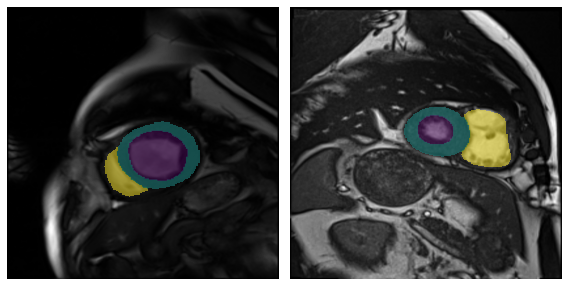

In [10]:
i, m = next(iter(dm.train_dataloader(batch_size=2)))
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
for idx in range(2):
    image = i[idx][0]
    axs[idx].imshow(image, cmap="gray")
    mascara = m[idx].float() # this is because change  tensors zero values to nan
    mascara[mascara == 0] = float('nan')
    axs[idx].imshow(mascara, alpha=0.5)
    axs[idx].axis('off')
plt.tight_layout()
plt.show()

In [11]:
class BaseModule(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        self.save_hyperparameters(hparams)

    def forward(self, x, y):
        raise NotImplementedError

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self(x)

    #def compute_loss(self, y_hat, y):
    #    loss = torch.mean(torch.sqrt(torch.mean((y_hat - y)**2, dim=(1, 2))))
    #    return loss

    def compute_metrics(self, y_hat, y):
        metric = accuracy_score(y_hat, y)
        return metric

    def compute_IoU(self, pr, gt, th=0.5, eps=1e-7):
        pr = torch.sigmoid(pr) > th
        gt = gt > th
        intersection = torch.sum(gt * pr, axis=(-2,-1))
        union = torch.sum(gt, axis=(-2,-1)) + torch.sum(pr, axis=(-2,-1)) - intersection + eps
        ious = (intersection + eps) / union
        return torch.mean(ious).item()


    def shared_step(self, batch):
        x, y = batch
        outputs = self(x, y)
        loss = outputs.loss

        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        y_hat = upsampled_logits.argmax(dim=1)
        pred_labels = y_hat.detach().cpu()
        true_labels = y.detach().cpu()
        metric = self.compute_IoU(pred_labels,true_labels)
        return loss, metric
        
    def training_step(self, batch, batch_idx):
        loss, metric = self.shared_step(batch)
        self.log('loss', loss)
        self.log('metric', metric, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, metric = self.shared_step(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_metric', metric, prog_bar=True)

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer)(
            self.parameters(), **self.hparams['optimizer_params'])
        if 'scheduler' in self.hparams:
            schedulers = [
                getattr(torch.optim.lr_scheduler, scheduler)(
                    optimizer, **params)
                for scheduler, params in self.hparams.scheduler.items()
            ]
            return [optimizer], schedulers
        return optimizer

In [12]:
class Segformer(BaseModule):
    def __init__(self, hparams=None):
        super().__init__(hparams)
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            self.hparams.name,
            ignore_mismatched_sizes=True,
            num_labels=self.hparams.num_labels,
            id2label= self.hparams.id2label,
            label2id= self.hparams.label2id,
            num_channels=self.hparams.num_channels,
            reshape_last_stage=True,
        )

    def forward(self, pixel_values, labels):
        out = self.model(pixel_values=pixel_values, labels=labels)
        return (out)

In [13]:
classes = { "backgrond" :  0,
            "type a" :  1,
            "type b" :  2,
            "type c" :  3,   
        }
id2label = classes
label2id = {v: k for k, v in id2label.items()}
id2label, label2id

({'backgrond': 0, 'type a': 1, 'type b': 2, 'type c': 3},
 {0: 'backgrond', 1: 'type a', 2: 'type b', 3: 'type c'})

In [14]:
# test the model
hparams = {
    'name': 'nvidia/mit-b5',
    'num_labels': len(id2label),
    'id2label': id2label,
    'label2id': label2id,
    'num_channels': 1
}
model = Segformer(hparams)
outputs = model(i, m)
outputs.logits.shape, outputs.loss.item()

Downloading:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.proj.weight', 'deco

(torch.Size([2, 4, 128, 128]), 1.25382661819458)

In [15]:
from transformers import AdamW
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
path_checkpoints = "/content/checkpoints" 
config = {
    'name': 'nvidia/mit-b5',
    'num_labels': len(id2label),
    'id2label': id2label,
    'label2id': label2id,
    'num_channels': 1,
    'optimizer': 'AdamW',
    'optimizer_params': {
        'lr': 0.00006
    },
    'trainer': {  
        'gpus': 1,
        'max_epochs': 10,
        'logger': True,
        'enable_checkpointing': False,
        'overfit_batches': 0,
        #'deterministic': False, #it's NOT working, you must to keep False
        'precision': 16,
        'log_every_n_steps': 64
    },
    'datamodule': {
        'batch_size': 2,
        'num_workers': 0,
        'pin_memory': False 
    },
}
torch.use_deterministic_algorithms(True) # it's working
def train(config, name):
    pl.seed_everything(21, workers=True)
    dm = DataModule(**config['datamodule'])

    module = Segformer(config)

    config['trainer']['callbacks'] = []
    if config['trainer']['enable_checkpointing']:
        config['trainer']['callbacks'] += [
            ModelCheckpoint(
                dirpath = path_checkpoints,
                filename=f'{name}-{{val_metric:.5f}}-{{epoch}}',
                monitor='val_metric',
                mode='max',
                save_top_k=1
            ),
            ModelCheckpoint( # i think it's all you need to Checkpointed the model in each epoch
                dirpath = path_checkpoints,
                filename=f'{name}-{{epoch}}',
                monitor='epoch',
                mode='max',
                save_top_k=1
            )
        ]
    if config['trainer']['logger']:
        config['trainer']['logger'] = WandbLogger(
            project="Unet",
            name=name,
            config=config
        )
        if 'scheduler' in config and config['scheduler']:
            config['trainer']['callbacks'] += [
                LearningRateMonitor(logging_interval='step')]

    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)

In [16]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
# material para ver 
# https://github.com/roboflow/notebooks/blob/main/notebooks/train-segformer-segmentation-on-custom-data.ipynb
train(config, "Segformer-nvidia/mit-b5")

INFO:lightning_lite.utilities.seed:Global seed set to 21
Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.

Training size: 2419
Testing size: 605


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 84.6 M
-----------------------------------------------------------
84.6 M    Trainable params
0         Non-trainable params
84.6 M    Total params
169.180   Total estimated model params size (MB)
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sandro_og. Use `wandb login --relogin` to force relogin


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,█▃▄▃▂▂▂▂▁▂▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
metric,▁▁▅▇▅▆▄██▇█▇█▇▇█▇▆▆██████▇██▆██████▆▇██▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▃▂▁▁▁▁▁▁
val_metric,▁▆▇▇██████
epoch,9
loss,0.04358
metric,0.81307
trainer/global_step,12099
val_loss,0.01201


In [ ]:
# 24:52 mim val_iou 0.827 , 13.7 M de parámetros nvidia/mit-b1
# 43:15 mim val_iou 0.856 , 27.3 M de parámetros nvidia/mit-b2
# 61:00 mim val_iou 0.890 , 47.2 M de parámetros nvidia/mit-b3
# 88:00 min val_iou 0.868 , 82.0 M de parámetros nvidia/mit-b5

In [ ]:
# comparativa resnet
# 19:49 mim val_iou 0.831 , 14.3 M de parámetros resnet18
# 21:35 mim val_iou 0.830 , 24.4 M de parámetros resnet34
# 32:53 mim val_iou 0.843 , 51.5 M de parámetros resnet101

In [ ]:
# 3 Epoch loss=0.0308, metric=0.426, val_loss=0.0201, val_metric=0.814 9min 
# 9 Epoch loss=0.0179, metric=0.859, val_loss=0.0136, val_metric=0.875 22 min , 13.7 M parámetros b1
# 9 Epoch loss=0.0145, metric=0.950, val_loss=0.0127, val_metric=0.869 44 min , 27.3 M parámetros b2
# 9 Epoch loss=0.0137, metric=0.930, val_loss=0.0122, val_metric=0.890 63 min , 47.2 M parámetros b3